# PISA Example Using Public IceCube Data

This analysis is a close variant of what is published in [1], and referred to as *Sample B* in [2] and [3]. The set of systematic uncertainties is slightly reduced and results will be close to, but not identical to the published numbers.

**References:**
* [1] “Measurement of Atmospheric Neutrino Oscillations at 6-56 GeV with IceCube DeepCore,” IceCube Collaboration: M. G. Aartsen et al., Physical Review Letters 120, 071801 (2018). DOI: 10.1103/PhysRevLett.120.071801
* [2] “Measurement of Atmospheric Tau Neutrino Appearance with IceCube DeepCore,” IceCube Collaboration: M. G. Aartsen et al., Phys. Rev. D99.3(2019), p. 032007. DOI: 10.1103/PhysRevD.99.032007
* [3] “Probing the Neutrino Mass Ordering with Atmospheric Neutrinos from Three Years of IceCube DeepCore Data,” IceCube Collaboration: M.G. Aartsen et al., Feb 20, 2019, preprint: arXiv:1902.07771

Dataset must be obtained from https://icecube.wisc.edu/science/data/highstats_nuosc_3y

## Setup

Usually you would need to export the location of the data, and the config files to `PISA_RESOURCES`. For this example however, the data is inside our package.

In [38]:
import numpy as np
from uncertainties import unumpy as unp
import matplotlib.pyplot as plt
import copy
import pisa
from pisa.core.distribution_maker import DistributionMaker
from pisa.core.pipeline import Pipeline
from pisa.analysis.analysis import Analysis
from pisa import FTYPE, ureg

## Model

We can now instantiate the `model` (given our configs) that we later fit to data. This now containes two `Pipelines` in a `DistributionMaker`, one for our neutrinos, and one for the background muons.

In [24]:
model = DistributionMaker(["settings/pipeline/IceCube_3y_neutrinos.cfg", "settings/pipeline/IceCube_3y_muons.cfg"])
# this just turns on profiling
model.profile = True
model

pipeline number,name,detector name,output_binning,output_key,profile
0,neutrinos,,"""dragon_datarelease"": 8 (reco_energy) x 8 (reco_coszen) x 2 (pid)","('weights', 'errors')",True
1,muons,,"""dragon_datarelease"": 8 (reco_energy) x 8 (reco_coszen) x 2 (pid)","('weights', 'errors')",True


Our model has a number of free parameters, that will be used in our fit to the data

In [25]:
model.params.free

name,value,nominal_value,range,prior,units,is_fixed
nue_numu_ratio,1,1,"[0.5, 1.5]",+/- 0.05,dimensionless,False
Barr_uphor_ratio,0,0,"[-3.0, 3.0]",+/- 1.0,dimensionless,False
Barr_nu_nubar_ratio,0,0,"[-3.0, 3.0]",+/- 1.0,dimensionless,False
delta_index,0,0,"[-0.5, 0.5]",+/- 0.1,dimensionless,False
theta13,8.5,8.5,"[7.85, 9.1]",+/- 0.205,degree,False
theta23,42.3,42.3,"[31, 59]",uniform,degree,False
deltam31,0.002457,0.002457,"[0.001, 0.007]",uniform,electron_volt ** 2,False
aeff_scale,1,1,"[0.0, 3.0]",uniform,dimensionless,False
nutau_norm,1,1,"[-1.0, 8.5]",uniform,dimensionless,False
nu_nc_norm,1,1,"[0.5, 1.5]",+/- 0.2,dimensionless,False


The two pipelines are quite different, with most complexity in the neutrino pipeline, that has several `Stage`s and free parameters:

In [26]:
model.pipelines[0]

stage number,name,calc_mode,apply_mode,has setup,has compute,has apply,# fixed params,# free params
0,csv_loader,events,events,True,False,True,0,0
1,honda_ip,"""true_allsky_fine"": 200 (true_energy) x 200 (true_coszen)",events,True,True,False,1,0
2,barr_simple,"""true_allsky_fine"": 200 (true_energy) x 200 (true_coszen)",events,True,True,False,1,4
3,prob3,"""true_allsky_fine"": 200 (true_energy) x 200 (true_coszen)",events,True,True,True,9,3
4,aeff,events,events,False,False,True,2,3
5,hist,events,"""dragon_datarelease"": 8 (reco_energy) x 8 (reco_coszen) x 2 (pid)",True,False,True,0,0
6,hypersurfaces,"""dragon_datarelease"": 8 (reco_energy) x 8 (reco_coszen) x 2 (pid)","""dragon_datarelease"": 8 (reco_energy) x 8 (reco_coszen) x 2 (pid)",True,True,True,0,5


In [27]:
model.pipelines[0].stages[2].params

name,value,nominal_value,range,prior,units,is_fixed
nu_nubar_ratio,1,1,"[0.7, 1.3]",+/- 0.1,1,True
nue_numu_ratio,1,1,"[0.5, 1.5]",+/- 0.05,1,False
Barr_uphor_ratio,0,0,"[-3.0, 3.0]",+/- 1.0,1,False
Barr_nu_nubar_ratio,0,0,"[-3.0, 3.0]",+/- 1.0,1,False
delta_index,0,0,"[-0.5, 0.5]",+/- 0.1,1,False


While the muon pipleine is rather simple

In [28]:
model.pipelines[1]

stage number,name,calc_mode,apply_mode,has setup,has compute,has apply,# fixed params,# free params
0,csv_icc_hist,"""dragon_datarelease"": 8 (reco_energy) x 8 (reco_coszen) x 2 (pid)","""dragon_datarelease"": 8 (reco_energy) x 8 (reco_coszen) x 2 (pid)",True,False,True,0,1


## Retrieve Outputs

We can get individual outputs from just a pipleine like so. This fetches outputs from the neutrino pipleine, which are 12 maps.

In [29]:
maps = model.pipelines[0].get_outputs()

In [30]:
maps.names

['nue_cc',
 'numu_cc',
 'nutau_cc',
 'nue_nc',
 'numu_nc',
 'nutau_nc',
 'nuebar_cc',
 'numubar_cc',
 'nutaubar_cc',
 'nuebar_nc',
 'numubar_nc',
 'nutaubar_nc']

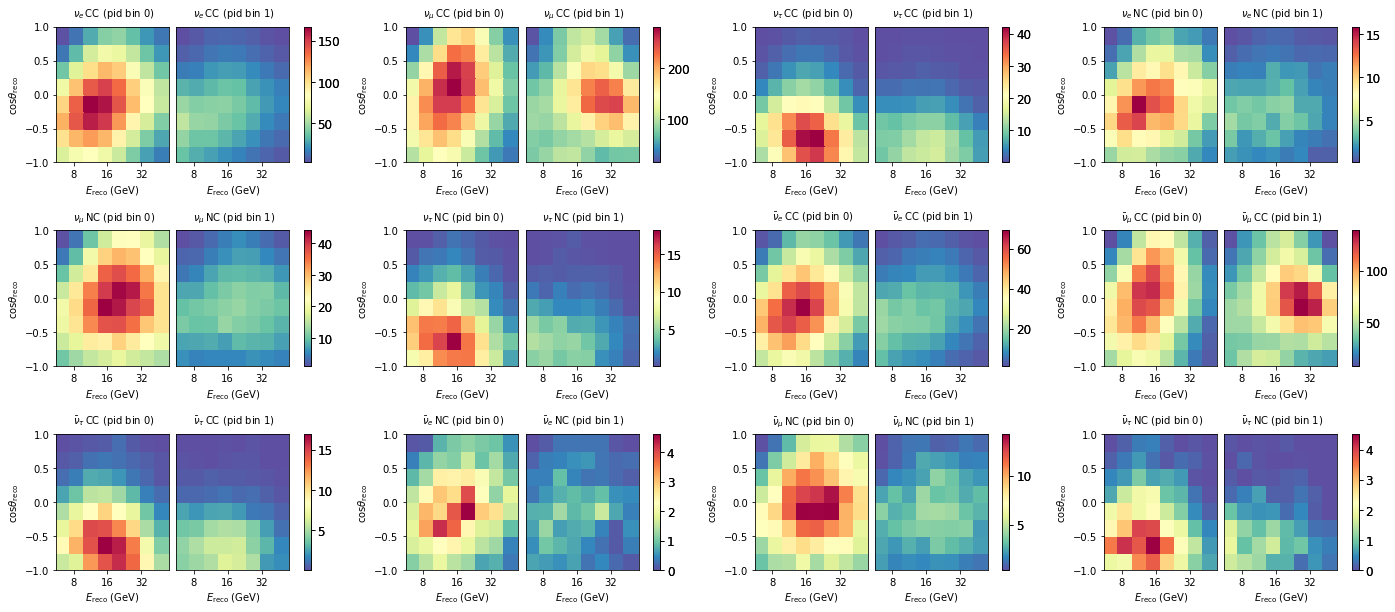

In [31]:
fig, axes = plt.subplots(3,4, figsize=(24,10))
plt.subplots_adjust(hspace=0.5)
axes = axes.flatten()

for m, ax in zip(maps, axes):
    m.plot(ax=ax)

If we are interested in just the total expecatation from the full model (all neutrinos + muons), we can do the following:

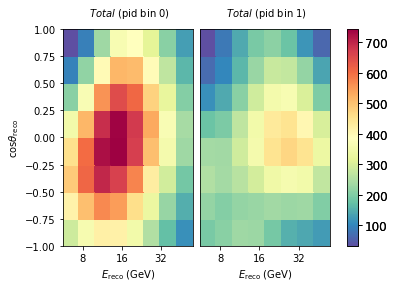

In [32]:
model.get_outputs(return_sum=True).plot()

## Diff plots

Let's explore how a change in one of our nuisance parameters affects the expected counts per bin. Here we choose a *hole ice* parameter and move it a smidge.

In [33]:
# reset all free parameters to put them back to nominal values
model.reset_free()
nominal = model.get_outputs(return_sum=True)

# shift one parameter
model.params.opt_eff_lateral.value = 20
sys = model.get_outputs(return_sum=True)

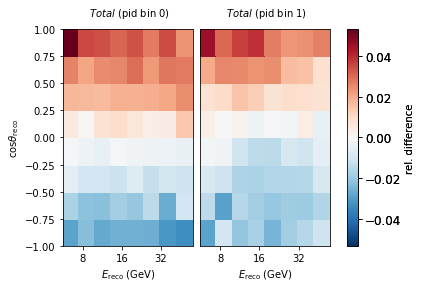

In [34]:
((nominal[0] - sys[0])/nominal[0]).plot(symm=True, clabel="rel. difference")

## Get Data

We can load the real observed data too. This is a Pipeline with no free parameters, as the data is of course fixed.
NB: When developping a new analysis you will **not** be allowed to look at the data as we do here before the box opening (c.f. *blindness*).

In [35]:
# real data
data_maker = Pipeline("settings/pipeline/IceCube_3y_data.cfg")
data = data_maker.get_outputs()

In [36]:
data_maker

stage number,name,calc_mode,apply_mode,has setup,has compute,has apply,# fixed params,# free params
0,csv_data_hist,events,"""dragon_datarelease"": 8 (reco_energy) x 8 (reco_coszen) x 2 (pid)",True,False,False,0,0


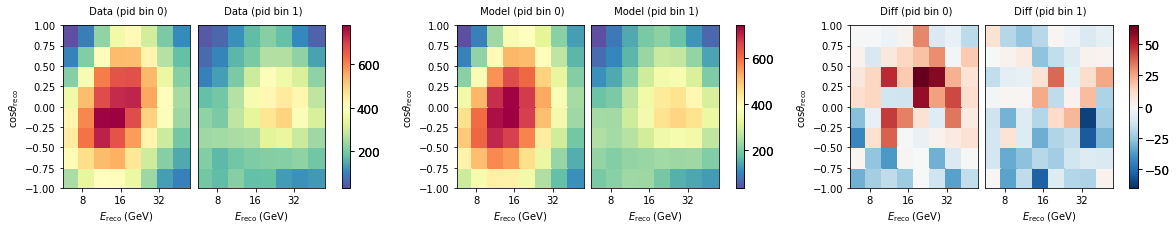

In [37]:
fig, ax = plt.subplots(1, 3, figsize=(20, 3))

model.reset_free()
nominal = model.get_outputs(return_sum=True)

data.plot(ax=ax[0], title="Data")
nominal.plot(ax=ax[1], title="Model")
(data - nominal).plot(ax=ax[2], symm=True, title="Diff")

## Fitting

For fitting we need to configure a minimizer, several standard cfgs are available, but you can also define your own.
For the fit we need to choose a `metric`, and by default, theta23 octants, which are quasi degenerate, are fit seperately, which means two fits are run.

In [39]:
minimizer_cfg = pisa.utils.fileio.from_file('settings/minimizer/slsqp_ftol1e-6_eps1e-4_maxiter1000.json')
ana = Analysis()

In [41]:
%%time
result = ana.fit_hypo(
         data,
         model,
         metric='mod_chi2',
         minimizer_settings=minimizer_cfg,
         fit_octants_separately=True,
        )

[ WARNING] Minimizer slsqp requires artificial boundaries SMALLER than the user-specified boundaries (so that numerical gradients do not exceed the user-specified boundaries).
                                                                                        (deg)        (deg)       (eV**2)                                                                                                                        
 iter   funcalls    mod_chi2   | nue_numu_rat Barr_uphor_r Barr_nu_nuba delta_index    theta13      theta23      deltam31    aeff_scale   nutau_norm   nu_nc_norm  opt_eff_over opt_eff_late opt_eff_head ice_scatteri ice_absorpti atm_muon_sca
------ ---------- ------------ + ------------ ------------ ------------ ------------ ------------ ------------ ------------ ------------ ------------ ------------ ------------ ------------ ------------ ------------ ------------ ------------
  0        6       1.75086e+02 |  1.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  8.50013e+00  4.

KeyboardInterrupt: 

Here we can view the bestfit parameters - the result of our fit.
We have run two fits (separately for each theta23 octant), and the best result is stored in `results[0]` (both fits are also available under `results[1]`)

In [18]:
bestfit_params = result[0]['params'].free
bestfit_params

name,value,nominal_value,range,prior,units,is_fixed
nue_numu_ratio,1.03304,1,"[0.5, 1.5]",+/- 0.05,dimensionless,False
Barr_uphor_ratio,-0.313404,0,"[-3.0, 3.0]",+/- 1.0,dimensionless,False
Barr_nu_nubar_ratio,-0.0200293,0,"[-3.0, 3.0]",+/- 1.0,dimensionless,False
delta_index,-0.0106011,0,"[-0.5, 0.5]",+/- 0.1,dimensionless,False
theta13,8.50992,8.5,"[7.85, 9.1]",+/- 0.205,degree,False
theta23,46.2525,42.3,"[31, 59]",uniform,degree,False
deltam31,0.00242605,0.002457,"[0.001, 0.007]",uniform,electron_volt ** 2,False
aeff_scale,0.934868,1,"[0.0, 3.0]",uniform,dimensionless,False
nutau_norm,0.610718,1,"[-1.0, 8.5]",uniform,dimensionless,False
nu_nc_norm,1.26342,1,"[0.5, 1.5]",+/- 0.2,dimensionless,False


In [19]:
# update the model with the bestfit (make a copy here, because we don't want our bestfit params to be affected (NB: stuff is passed by reference in python))
model.update_params(copy.deepcopy(bestfit_params))

Let's see how good that fit looks like. We here construct signed mod_chi2 maps by hand.
You can see that after the fit, it improved considerably, and the distribution of chi2 values is now more uniform - not much features can be seen anymore.

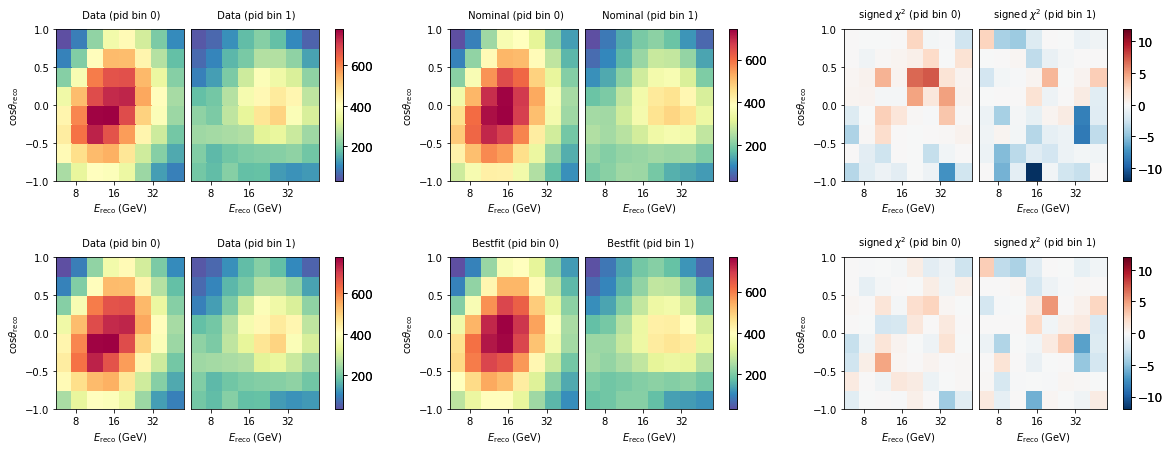

In [20]:
fig, ax = plt.subplots(2, 3, figsize=(20, 7))
plt.subplots_adjust(hspace=0.5)

bestfit = model.get_outputs(return_sum=True)

data.plot(ax=ax[0,0], title="Data")
nominal.plot(ax=ax[0,1], title="Nominal")
diff = data - nominal
(abs(diff)*diff/(nominal + unp.std_devs(nominal.hist['total']))).plot(ax=ax[0,2], symm=True, title=r"signed $\chi^2$", vmin=-12, vmax=12)

data.plot(ax=ax[1,0], title="Data")
bestfit.plot(ax=ax[1,1], title="Bestfit")
diff = data - bestfit
(abs(diff)*diff/(bestfit + unp.std_devs(bestfit.hist['total']))).plot(ax=ax[1,2], symm=True, title=r"signed $\chi^2$", vmin=-12, vmax=12)

When checking the chi2 value from the fitted model, you maybe see that it is around 113, while in the minimizer loop we saw it converged to 116. It is important to keep in mind that in the fit we had extended the metric with prior penalty terms. When we add those back we get the identical number as reported in the fit.

In [21]:
print(data.metric_total(nominal, 'mod_chi2'))
print(data.metric_total(bestfit, 'mod_chi2'))

175.08610154304426
113.03553972952989


Evaluating other metrics just for fun:

In [22]:
for metric in pisa.utils.stats.ALL_METRICS:
    try:
        print('%s = %.3f'%(metric,data.metric_total(bestfit, metric)))
    except:
        print('%s failed'%metric)

llh = -64.972
conv_llh = -57.326
barlow_llh = -1147.290
mcllh_mean = -541.333
mcllh_eff = -541.486
generalized_poisson_llh failed
chi2 = 128.476
mod_chi2 = 113.036


Adding prior penalty terms

In [23]:
model.update_params(copy.deepcopy(bestfit_params))
data.metric_total(bestfit, 'mod_chi2') + model.params.priors_penalty('mod_chi2')

115.8086745310561

In [24]:
result[0]['metric_val']

115.8086745310561

## Storing the results to a file

Since the fit took a while, it might be useful to store the results to a file. (NB: in this example we use a temp file, but in real life you would of course just use a real pathname instead!)

In [25]:
import tempfile
temp = tempfile.NamedTemporaryFile(suffix='.json')
pisa.utils.fileio.to_file(result, temp.name)

[ WARNING] Overwriting file at '/tmp/tmp04yxkl60.json'


To reload, we can read the file. But to get PISA objects back, they need to instantiated

In [26]:
result_reload = pisa.utils.fileio.from_file(temp.name)
bestfit_params = pisa.core.ParamSet(result_reload[0]['params']).free
bestfit_params
temp.close()

## Profiling

To understand what parts of the model were executed how many times, and how long it took, the profiling  can help:

In [27]:
model.pipelines[0].report_profile()

data csv_loader
- setup:  Total time 0.00000 s, n calls: 0, time/call: 0.00000 s
- calc:   Total time 0.00000 s, n calls: 0, time/call: 0.00000 s
- apply:  Total time 1.34596 s, n calls: 817, time/call: 0.00165 s
flux honda_ip
- setup:  Total time 0.00000 s, n calls: 0, time/call: 0.00000 s
- calc:   Total time 25.08353 s, n calls: 1, time/call: 25.08353 s
- apply:  Total time 0.00072 s, n calls: 817, time/call: 0.00000 s
flux barr_simple
- setup:  Total time 0.00000 s, n calls: 0, time/call: 0.00000 s
- calc:   Total time 118.13966 s, n calls: 330, time/call: 0.35800 s
- apply:  Total time 0.00091 s, n calls: 817, time/call: 0.00000 s
osc prob3
- setup:  Total time 0.00000 s, n calls: 0, time/call: 0.00000 s
- calc:   Total time 339.71126 s, n calls: 290, time/call: 1.17142 s
- apply:  Total time 73.15262 s, n calls: 817, time/call: 0.08954 s
aeff aeff
- setup:  Total time 0.00000 s, n calls: 0, time/call: 0.00000 s
- calc:   Total time 0.00056 s, n calls: 290, time/call: 0.00000 s
- 